# Packages

In [ ]:
! pip install prince

In [ ]:
! pip install imbalanced-learn

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import prince
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split, learning_curve

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score,precision_score, recall_score, precision_recall_curve, f1_score, normalized_mutual_info_score, adjusted_rand_score 

from imblearn.over_sampling import SMOTE # For imbalanced
from scipy.io import loadmat
from sklearn.decomposition import TruncatedSVD
import warnings
warnings.filterwarnings('ignore')

# Cora

Cora est composé de 03 matrices:

*   fea: une matrice Document-Term
*   W: matrice de similarité entre Documents
*   gnd: les étiquettes (7 classes)<br>
On ajoute la matrice : M = D$^{-1}$\*W\*fea



---



1. **Exploration des données:**<br>
L'exploration des données sur les labels donne 7 classes déséquilibrées.<br>
Pour avoir une projection des données avec la matrice **fea**, on applique **LSA(Latent Semantic Analysis)** qui est une méthode de réduction de dimension plus adaptée sur les matrices Document-Term ( matrice sparse).<br> La projection sur les premiers axes montre la structure de classes non linéairement séparables. <br>
La matrice **fea** ne tient pas compte de la similarité entre les documents; cette information est stockée sur la matrice W.<br>
En prenant la combinaison des deux matrices **fea** et **W**, ce qui correspond à la matrice **M**, On obtient une séparabilité plus nette des classes après application de **LSA** sur la matrice **M**.<br>
Ces résultats nous donnent un petit aperçu sur les types d'algorithmes (linéaires, quadratiques, arbre de décisions, ...) susceptible d'être cohérents sur le jeu de données.<br>
On va appliquer un ensemble d'algorithmes sur la matrice **fea** puis sur la matrice **M**. Deux approches seront utilisées, la première consiste à conserver le deséquilibre des classes et la seconde, consiste à appliquer une méthode de rééchantillonnage pour avoir des classes équilibrées.






In [ ]:
cora_data = loadmat("/content/drive/MyDrive/Donnees_relationnelles/cora.mat")
fea = cora_data['fea']
W = cora_data['W']
gnd = cora_data['gnd']
M = np.linalg.inv(np.diag(W.sum(axis=1))).dot(W).dot(fea)
models = [Bayesien, KNN, LDA, QDA, SVM_linear, SVM_rbf, RandomForest,Xgboost]

In [ ]:
def evaluation(models):
  pos=1
  plt.figure(figsize=(20,15))
  for model in models:
    plt.subplot(3,3,pos)
    model.fit(X_train, y_train) 
    N, train_score, val_score = learning_curve(model, X_train, y_train, cv = 4, scoring ='f1', train_sizes = np.linspace(0.1, 1, 10))
    plt.plot(N, train_score.mean(axis = 1), label= 'train score')
    plt.plot(N, val_score.mean(axis = 1), label = 'validation score')
    plt.title(Names[pos-1])
    plt.legend()
    pos+=1

In [ ]:
def scores(models):
  model_scores = []
  for model in models:
    model.fit(X_train, y_train)
    pred_labels = model.predict(X_test)
    model_scores.append([accuracy_score(y_test, pred_labels), 
                         recall_score(y_test, pred_labels, average="micro"), 
                         precision_score(y_test, pred_labels, average="micro"),
                         f1_score(y_test, pred_labels,average="micro"),normalized_mutual_info_score(y_test, pred_labels), adjusted_rand_score(y_test, pred_labels)])
  
  model_scores = pd.DataFrame(model_scores)
  model_scores.index = Names
  model_scores.columns = ["Accuracy", "Recall", "Precision", "F1", "NMI", "ARI"]
  return model_scores

## Exploration des données

L'exploration des données montrent des classes déséquilibrées. Un reéchantillonage des données serait intéréssante pour résoudre ce problème.

La projection des données sur l'espace des features et sur la combinaison des matrices avec LSA (plus adapté sur des matrices sparses) donne des classes non-linéairement séparables sur les premiers axes.

Text(0, 0.5, "Nombre d'observations")

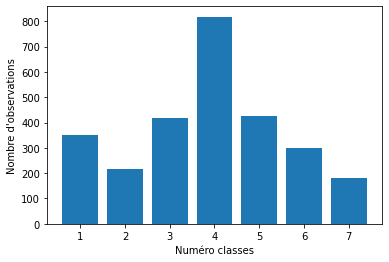

In [ ]:
# Distribution des classes
unique, counts = np.unique(gnd, return_counts=True)
plt.bar(unique, counts)
plt.xlabel("Numéro classes")
plt.ylabel("Nombre d'observations")

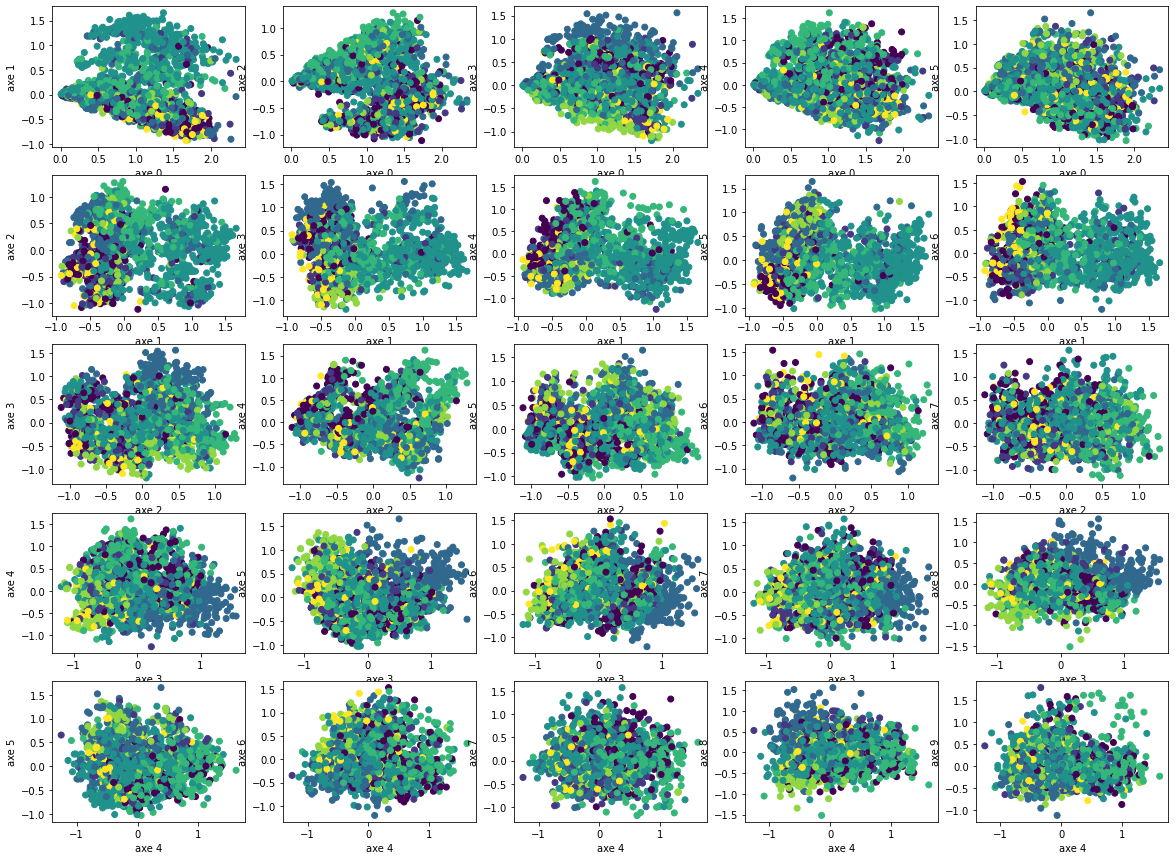

In [ ]:
# Projection sur l'espace des features
svd = TruncatedSVD(n_components=10).fit(fea)
X = svd.transform(fea)
pos = 1
plt.figure(figsize=(20,15))
for i in range(5):
  for j in range(i+1, i+5+1):
    plt.subplot(5,5,pos)
    plt.scatter(X[:,i], X[:,j], c=gnd.flatten())
    plt.xlabel(f"axe {i}")
    plt.ylabel(f"axe {j}")
    pos+=1

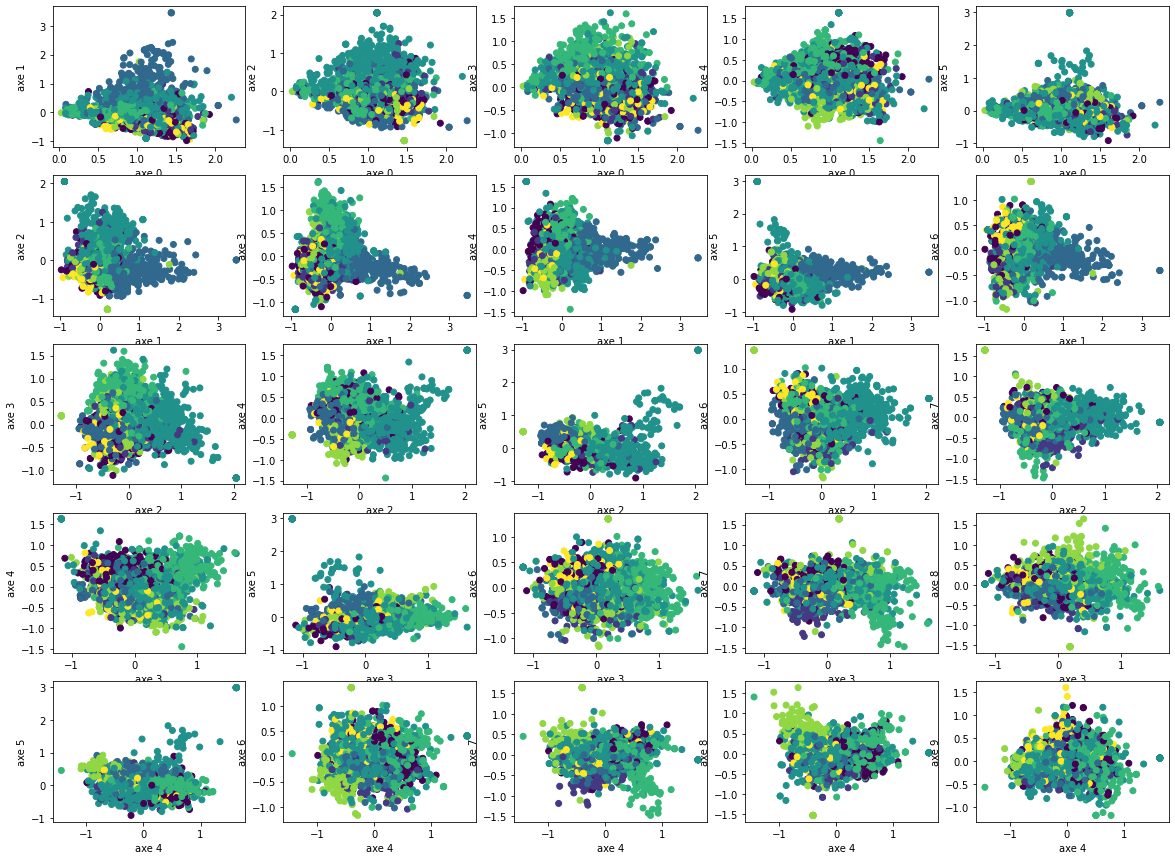

In [ ]:
# Projection sur la combinaison des matrices
svd = TruncatedSVD(n_components=10).fit(M)
X = svd.transform(M)
pos = 1
plt.figure(figsize=(20,15))
for i in range(5):
  for j in range(i+1, i+5+1):
    plt.subplot(5,5,pos)
    plt.scatter(X[:,i], X[:,j], c=gnd.flatten())
    plt.xlabel(f"axe {i}")
    plt.ylabel(f"axe {j}")
    pos+=1

## Baseline (classes déséquilibrées)

### Matrice fea

#### Application directe sans transformation

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(fea, gnd.flatten(),train_size=0.7)
Names  = ["Bayesien", "KNN", "LDA", "QDA", "SVM_linear", "SVM_rbf", "RandomForest","Xgboost"]

In [ ]:
evaluation(models)

In [ ]:
scores(models)

Accuracy    Recall  Precision        F1       NMI       ARI
Bayesien      0.504305  0.504305   0.504305  0.504305  0.197068  0.180328
KNN           0.432964  0.432964   0.432964  0.432964  0.157392  0.125983
LDA           0.521525  0.521525   0.521525  0.521525  0.220680  0.197533
QDA           0.140221  0.140221   0.140221  0.140221  0.019627  0.017448
SVM_linear    0.722017  0.722017   0.722017  0.722017  0.451757  0.477545
SVM_rbf       0.756458  0.756458   0.756458  0.756458  0.540386  0.491587
RandomForest  0.768758  0.768758   0.768758  0.768758  0.535994  0.538305
Xgboost       0.731857  0.731857   0.731857  0.731857  0.497765  0.435697

#### Application avec transformation LSA

In [ ]:
svd = TruncatedSVD(500).fit(fea)
X = svd.transform(fea)
X_train, X_test, y_train, y_test = train_test_split(X, gnd.flatten(),train_size=0.7)

In [ ]:
evaluation(models)

In [ ]:
scores(models)

Accuracy    Recall  Precision        F1       NMI       ARI
Bayesien      0.567036  0.567036   0.567036  0.567036  0.260159  0.254579
KNN           0.532595  0.532595   0.532595  0.532595  0.238363  0.235107
LDA           0.725707  0.725707   0.725707  0.725707  0.473085  0.463139
QDA           0.308733  0.308733   0.308733  0.308733  0.012541  0.002049
SVM_linear    0.682657  0.682657   0.682657  0.682657  0.401111  0.423980
SVM_rbf       0.715867  0.715867   0.715867  0.715867  0.484456  0.442710
RandomForest  0.510455  0.510455   0.510455  0.510455  0.250431  0.143086
Xgboost       0.639606  0.639606   0.639606  0.639606  0.355055  0.363342

### Matrice combinée

#### Application directe sans transformation

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(M, gnd.flatten(),train_size=0.7)

In [ ]:
evaluation(models)

In [ ]:
scores(models)

Accuracy    Recall  Precision        F1       NMI       ARI
Bayesien      0.717097  0.717097   0.717097  0.717097  0.466378  0.444023
KNN           0.785978  0.785978   0.785978  0.785978  0.594426  0.552868
LDA           0.639606  0.639606   0.639606  0.639606  0.362113  0.340335
QDA           0.257073  0.257073   0.257073  0.257073  0.154105  0.012365
SVM_linear    0.804428  0.804428   0.804428  0.804428  0.594972  0.611654
SVM_rbf       0.815498  0.815498   0.815498  0.815498  0.617944  0.605025
RandomForest  0.836408  0.836408   0.836408  0.836408  0.648393  0.647501
Xgboost       0.813038  0.813038   0.813038  0.813038  0.595791  0.617736

#### Application avec transformation LSA

In [ ]:
svd = TruncatedSVD(500).fit(M)
X = svd.transform(M)
X_train, X_test, y_train, y_test = train_test_split(X, gnd.flatten(),train_size=0.7)

In [ ]:
evaluation(models)

In [ ]:
scores(models)

Accuracy    Recall  Precision        F1       NMI       ARI
Bayesien      0.496925  0.496925   0.496925  0.496925  0.249769  0.147420
KNN           0.806888  0.806888   0.806888  0.806888  0.603758  0.607697
LDA           0.814268  0.814268   0.814268  0.814268  0.602012  0.610795
QDA           0.350554  0.350554   0.350554  0.350554  0.106659  0.015395
LogisticR     0.826568  0.826568   0.826568  0.826568  0.621079  0.639016
SVM_linear    0.815498  0.815498   0.815498  0.815498  0.604639  0.618914
SVM_rbf       0.821648  0.821648   0.821648  0.821648  0.619092  0.611312
RandomForest  0.767528  0.767528   0.767528  0.767528  0.555801  0.489466
Bagging       0.830258  0.830258   0.830258  0.830258  0.631777  0.627275
Xgboost       0.793358  0.793358   0.793358  0.793358  0.565947  0.581800

## Imbalanced learn

### Matrice fea

In [ ]:
oversample = SMOTE()
X_oversample, y_oversample = oversample.fit_resample(fea, gnd.flatten())

#### Application directe sans transformation

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_oversample, y_oversample,train_size=0.7)
models = [Bayesien, KNN, LDA, QDA, SVM_linear, SVM_rbf, RandomForest,Xgboost]
Names  = ["Bayesien", "KNN", "LDA", "QDA", "SVM_linear", "SVM_rbf", "RandomForest","Xgboost"]

In [ ]:
evaluation(models)

In [ ]:
scores(models)

Accuracy    Recall  Precision        F1       NMI       ARI
Bayesien      0.745634  0.745634   0.745634  0.745634  0.551958  0.489669
KNN           0.588475  0.588475   0.588475  0.588475  0.314481  0.274435
LDA           0.511641  0.511641   0.511641  0.511641  0.326963  0.150834
QDA           0.739814  0.739814   0.739814  0.739814  0.607856  0.524303
SVM_linear    0.838766  0.838766   0.838766  0.838766  0.642442  0.663376
SVM_rbf       0.490105  0.490105   0.490105  0.490105  0.315833  0.122288
RandomForest  0.898137  0.898137   0.898137  0.898137  0.760141  0.781061
Xgboost       0.855646  0.855646   0.855646  0.855646  0.676775  0.693249

#### Application avec transformation LSA

In [ ]:
svd = TruncatedSVD(500).fit(X_oversample)
X = svd.transform(X_oversample)
X_train, X_test, y_train, y_test = train_test_split(X_oversample, y_oversample.flatten(),train_size=0.7)

In [ ]:
evaluation(models)

In [ ]:
scores(models)

Accuracy    Recall  Precision        F1       NMI       ARI
Bayesien      0.735157  0.735157   0.735157  0.735157  0.533789  0.462032
KNN           0.558789  0.558789   0.558789  0.558789  0.298227  0.253851
LDA           0.509313  0.509313   0.509313  0.509313  0.318792  0.146416
QDA           0.763679  0.763679   0.763679  0.763679  0.687428  0.598512
SVM_linear    0.830617  0.830617   0.830617  0.830617  0.630342  0.645679
SVM_rbf       0.506403  0.506403   0.506403  0.506403  0.338125  0.129358
RandomForest  0.890570  0.890570   0.890570  0.890570  0.755785  0.762403
Xgboost       0.830617  0.830617   0.830617  0.830617  0.640162  0.644780

### Matrice combinée

In [ ]:
oversample = SMOTE()
X_oversample, y_oversample = oversample.fit_resample(M, gnd.flatten())

#### Application directe sans transformation

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_oversample, y_oversample.flatten(),train_size=0.7)

In [ ]:
evaluation(models)

In [ ]:
scores(models)

Accuracy    Recall  Precision        F1       NMI       ARI
Bayesien      0.921420  0.921420   0.921420  0.921420  0.820846  0.829724
KNN           0.890570  0.890570   0.890570  0.890570  0.763902  0.768439
LDA           0.898719  0.898719   0.898719  0.898719  0.780192  0.787701
QDA           0.927823  0.927823   0.927823  0.927823  0.865315  0.830746
SVM_linear    0.942375  0.942375   0.942375  0.942375  0.863836  0.873219
SVM_rbf       0.923749  0.923749   0.923749  0.923749  0.826874  0.830216
RandomForest  0.933644  0.933644   0.933644  0.933644  0.839434  0.851881
Xgboost       0.917346  0.917346   0.917346  0.917346  0.801210  0.816660

#### Application avec transformation LSA

In [ ]:
svd = TruncatedSVD(500).fit(X_oversample)
X = svd.transform(X_oversample)
X_train, X_test, y_train, y_test = train_test_split(X_oversample, y_oversample.flatten(),train_size=0.7)

In [ ]:
evaluation(models)

In [ ]:
scores(models)

Accuracy    Recall  Precision        F1       NMI       ARI
Bayesien      0.909197  0.909197   0.909197  0.909197  0.794256  0.807779
KNN           0.905704  0.905704   0.905704  0.905704  0.784856  0.796317
LDA           0.899302  0.899302   0.899302  0.899302  0.776612  0.790099
QDA           0.920838  0.920838   0.920838  0.920838  0.855053  0.817401
SVM_linear    0.935390  0.935390   0.935390  0.935390  0.843385  0.859006
SVM_rbf       0.933062  0.933062   0.933062  0.933062  0.844691  0.849338
RandomForest  0.924913  0.924913   0.924913  0.924913  0.822776  0.834358
Xgboost       0.912689  0.912689   0.912689  0.912689  0.794621  0.809456

# Citeseer

In [ ]:
cora_data = loadmat("/content/drive/MyDrive/Donnees_relationnelles/citeseer.mat")
fea = cora_data['fea']
W = cora_data['W']
gnd = cora_data['gnd']
M = np.linalg.inv(np.diag(W.sum(axis=1))).dot(W).dot(fea)

In [ ]:
models = [Bayesien, KNN, LDA, QDA, SVM_linear, SVM_rbf, RandomForest,Xgboost]

In [ ]:
def evaluation(models):
  pos=1
  plt.figure(figsize=(20,15))
  for model in models:
    plt.subplot(3,3,pos)
    model.fit(X_train, y_train) 
    N, train_score, val_score = learning_curve(model, X_train, y_train, cv = 4, scoring ='f1', train_sizes = np.linspace(0.1, 1, 10))
    plt.plot(N, train_score.mean(axis = 1), label= 'train score')
    plt.plot(N, val_score.mean(axis = 1), label = 'validation score')
    plt.title(Names[pos-1])
    plt.legend()
    pos+=1

In [ ]:
def scores(models):
  model_scores = []
  for model in models:
    model.fit(X_train, y_train)
    pred_labels = model.predict(X_test)
    model_scores.append([accuracy_score(y_test, pred_labels), 
                         recall_score(y_test, pred_labels, average="micro"), 
                         precision_score(y_test, pred_labels, average="micro"),
                         f1_score(y_test, pred_labels,average="micro"),normalized_mutual_info_score(y_test, pred_labels), adjusted_rand_score(y_test, pred_labels)])
  
  model_scores = pd.DataFrame(model_scores)
  model_scores.index = Names
  model_scores.columns = ["Accuracy", "Recall", "Precision", "F1", "NMI", "ARI"]
  return model_scores

## Exploration des données

L'exploration des données montrent des classes déséquilibrées. Un reéchantillonage des données serait intéréssante pour résoudre ce problème.

La projection des données sur l'espace des features et sur la combinaison des matrices avec LSA (plus adapté sur des matrices sparses) donne des classes non-linéairement séparables sur les premiers axes.

Text(0, 0.5, "Nombre d'observations")

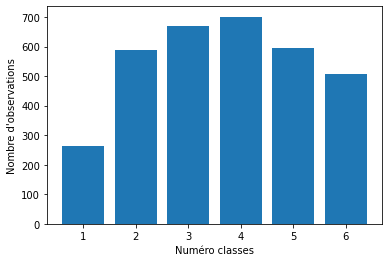

In [ ]:
# Distribution des classes
unique, counts = np.unique(gnd, return_counts=True)
plt.bar(unique, counts)
plt.xlabel("Numéro classes")
plt.ylabel("Nombre d'observations")

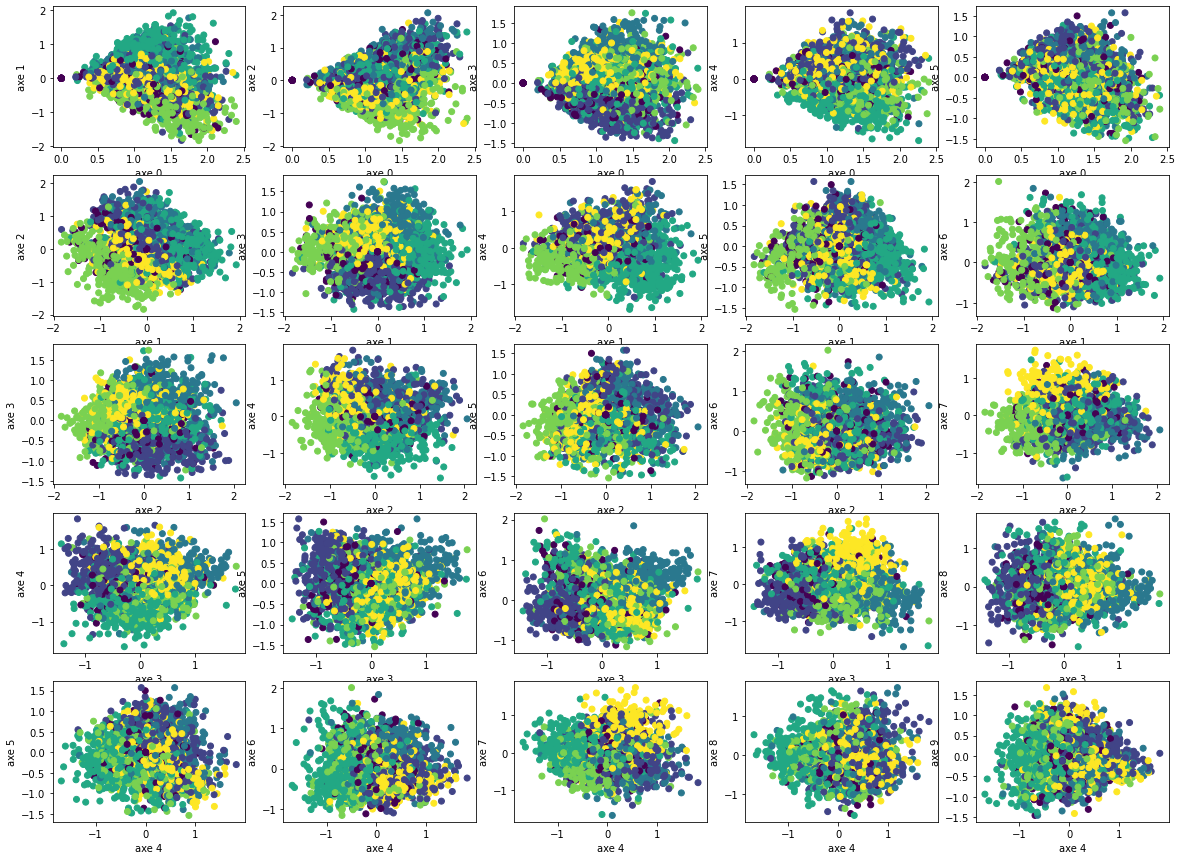

In [ ]:
# Projection sur l'espace des features
svd = TruncatedSVD(n_components=10).fit(fea)
X = svd.transform(fea)
pos = 1
plt.figure(figsize=(20,15))
for i in range(5):
  for j in range(i+1, i+5+1):
    plt.subplot(5,5,pos)
    plt.scatter(X[:,i], X[:,j], c=gnd.flatten())
    plt.xlabel(f"axe {i}")
    plt.ylabel(f"axe {j}")
    pos+=1

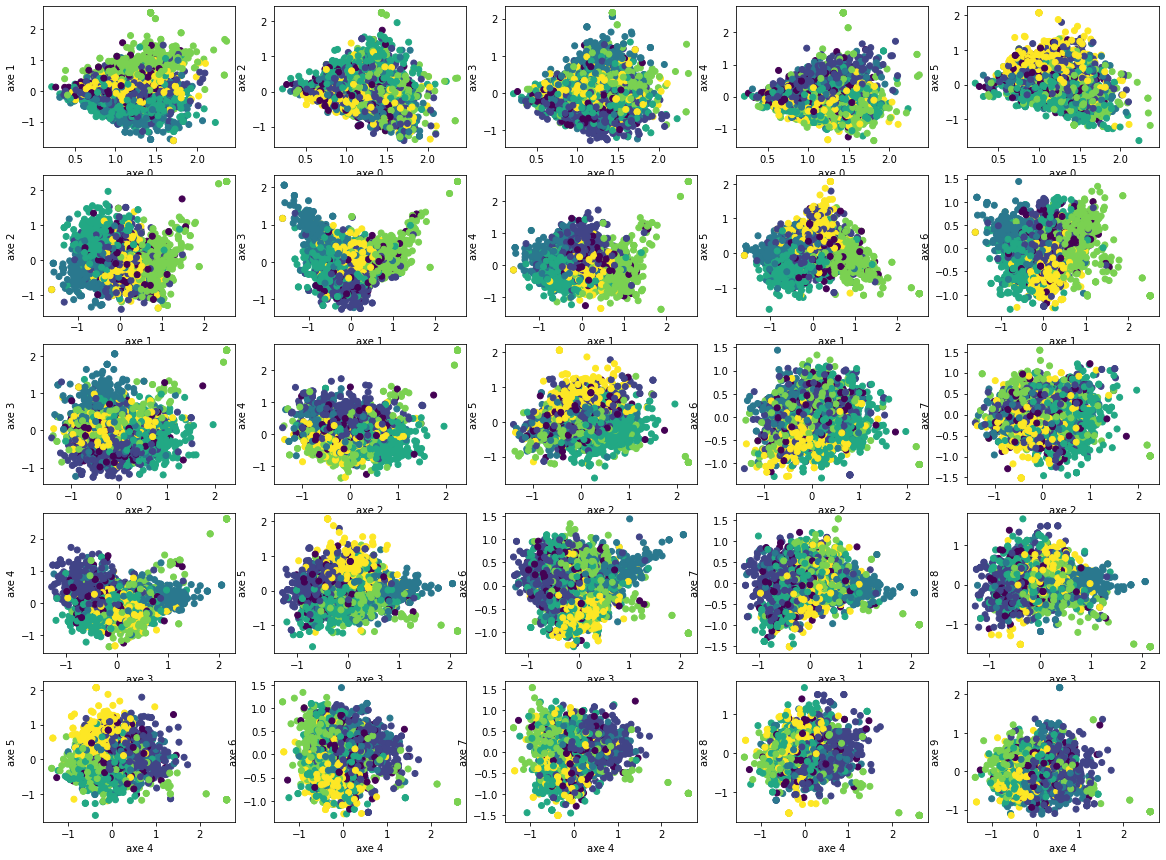

In [ ]:
# Projection sur la combinaison des matrices
svd = TruncatedSVD(n_components=10).fit(M)
X = svd.transform(M)
pos = 1
plt.figure(figsize=(20,15))
for i in range(5):
  for j in range(i+1, i+5+1):
    plt.subplot(5,5,pos)
    plt.scatter(X[:,i], X[:,j], c=gnd.flatten())
    plt.xlabel(f"axe {i}")
    plt.ylabel(f"axe {j}")
    pos+=1

## Baseline (classes déséquilibrées)

### Matrice fea

#### Application directe sans transformation

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(fea, gnd.flatten(),train_size=0.7)
models = [Bayesien, KNN, LDA, QDA, SVM_linear, SVM_rbf, RandomForest,Xgboost]
Names  = ["Bayesien", "KNN", "LDA", "QDA", "SVM_linear", "SVM_rbf", "RandomForest","Xgboost"]

In [ ]:
models = [Bayesien, KNN, LDA, QDA, SVM_linear, SVM_rbf, RandomForest,Xgboost]
Names = ["Bayesien", "KNN", "LDA", "QDA", "SVM_linear", "SVM_rbf", "RandomForest","Xgboost"]

In [ ]:
evaluation(models)

In [ ]:
scores(models)

Accuracy    Recall  Precision        F1       NMI       ARI
Bayesien      0.628629  0.628629   0.628629  0.628629  0.319153  0.315942
KNN           0.086086  0.086086   0.086086  0.086086  0.003567 -0.000286
LDA           0.381381  0.381381   0.381381  0.381381  0.094788  0.086997
QDA           0.220220  0.220220   0.220220  0.220220  0.018318  0.003172
SVM_linear    0.683684  0.683684   0.683684  0.683684  0.390398  0.406869
SVM_rbf       0.726727  0.726727   0.726727  0.726727  0.461366  0.477338
RandomForest  0.708709  0.708709   0.708709  0.708709  0.423698  0.443760
Xgboost       0.714715  0.714715   0.714715  0.714715  0.434614  0.454624

#### Application avec transformation LSA

In [ ]:
svd = TruncatedSVD(500).fit(fea)
X = svd.transform(fea)
X_train, X_test, y_train, y_test = train_test_split(X, gnd.flatten(),train_size=0.7)

In [ ]:
evaluation(models)

In [ ]:
scores(models)

Accuracy    Recall  Precision        F1       NMI       ARI
Bayesien      0.615616  0.615616   0.615616  0.615616  0.298951  0.315553
KNN           0.111111  0.111111   0.111111  0.111111  0.052821 -0.001298
LDA           0.696697  0.696697   0.696697  0.696697  0.404110  0.421720
QDA           0.205205  0.205205   0.205205  0.205205  0.015285  0.001784
SVM_linear    0.645646  0.645646   0.645646  0.645646  0.342726  0.348123
SVM_rbf       0.738739  0.738739   0.738739  0.738739  0.465364  0.492832
RandomForest  0.633634  0.633634   0.633634  0.633634  0.323347  0.325720
Xgboost       0.669670  0.669670   0.669670  0.669670  0.369456  0.385629

### Matrice combinée

#### Application directe sans transformation

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(M, gnd.flatten(),train_size=0.7)

In [ ]:
evaluation(models)

In [ ]:
scores(models)

Accuracy    Recall  Precision        F1       NMI       ARI
Bayesien      0.658659  0.658659   0.658659  0.658659  0.354990  0.371851
KNN           0.574575  0.574575   0.574575  0.574575  0.329878  0.239431
LDA           0.496496  0.496496   0.496496  0.496496  0.176188  0.165849
QDA           0.406406  0.406406   0.406406  0.406406  0.130506  0.107712
SVM_linear    0.671672  0.671672   0.671672  0.671672  0.377363  0.393843
SVM_rbf       0.722723  0.722723   0.722723  0.722723  0.454110  0.468623
RandomForest  0.711712  0.711712   0.711712  0.711712  0.439150  0.457868
Xgboost       0.712713  0.712713   0.712713  0.712713  0.433638  0.450835

#### Application avec transformation LSA

In [ ]:
svd = TruncatedSVD(500).fit(M)
X = svd.transform(M)
X_train, X_test, y_train, y_test = train_test_split(X, gnd.flatten(),train_size=0.7)

In [ ]:
evaluation(models)

In [ ]:
scores(models)

Accuracy    Recall  Precision        F1       NMI       ARI
Bayesien      0.377377  0.377377   0.377377  0.377377  0.120167  0.070394
KNN           0.641642  0.641642   0.641642  0.641642  0.373408  0.332794
LDA           0.699700  0.699700   0.699700  0.699700  0.420120  0.441947
QDA           0.613614  0.613614   0.613614  0.613614  0.326482  0.319616
SVM_linear    0.676677  0.676677   0.676677  0.676677  0.378268  0.397054
SVM_rbf       0.715716  0.715716   0.715716  0.715716  0.437121  0.458750
RandomForest  0.671672  0.671672   0.671672  0.671672  0.377101  0.382214
Xgboost       0.696697  0.696697   0.696697  0.696697  0.401836  0.435343

## Imbalanced learn

### Matrice fea

In [ ]:
oversample = SMOTE()
X_oversample, y_oversample = oversample.fit_resample(fea, gnd.flatten())

#### Application directe sans transformation

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_oversample, y_oversample,train_size=0.7)
models = [Bayesien, KNN, LDA, QDA, SVM_linear, SVM_rbf, RandomForest,Xgboost]
Names  = ["Bayesien", "KNN", "LDA", "QDA", "SVM_linear", "SVM_rbf", "RandomForest","Xgboost"]

In [ ]:
evaluation(models)

In [ ]:
scores(models)

Accuracy    Recall  Precision        F1       NMI       ARI
Bayesien      0.699683  0.699683   0.699683  0.699683  0.444333  0.416996
KNN           0.193344  0.193344   0.193344  0.193344  0.065055  0.002301
LDA           0.396197  0.396197   0.396197  0.396197  0.147369  0.127364
QDA           0.399366  0.399366   0.399366  0.399366  0.240594  0.139950
SVM_linear    0.749604  0.749604   0.749604  0.749604  0.486761  0.491562
SVM_rbf       0.250396  0.250396   0.250396  0.250396  0.092798  0.027127
RandomForest  0.759905  0.759905   0.759905  0.759905  0.501485  0.514203
Xgboost       0.737718  0.737718   0.737718  0.737718  0.469689  0.476794

#### Application avec transformation LSA

In [ ]:
svd = TruncatedSVD(500).fit(X_oversample)
X = svd.transform(X_oversample)
X_train, X_test, y_train, y_test = train_test_split(X_oversample, y_oversample.flatten(),train_size=0.7)

In [ ]:
evaluation(models)

In [ ]:
scores(models)

Accuracy    Recall  Precision        F1       NMI       ARI
Bayesien      0.697306  0.697306   0.697306  0.697306  0.444540  0.406293
KNN           0.209984  0.209984   0.209984  0.209984  0.072107  0.004697
LDA           0.391442  0.391442   0.391442  0.391442  0.145321  0.122738
QDA           0.390650  0.390650   0.390650  0.390650  0.283346  0.109448
SVM_linear    0.751981  0.751981   0.751981  0.751981  0.482272  0.493151
SVM_rbf       0.245642  0.245642   0.245642  0.245642  0.090254  0.023328
RandomForest  0.774960  0.774960   0.774960  0.774960  0.521923  0.536620
Xgboost       0.759113  0.759113   0.759113  0.759113  0.499949  0.509439

### Matrice combinée

In [ ]:
oversample = SMOTE()
X_oversample, y_oversample = oversample.fit_resample(M, gnd.flatten())

#### Application directe sans transformation

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_oversample, y_oversample.flatten(),train_size=0.7)

In [ ]:
evaluation(models)

In [ ]:
scores(models)

Accuracy    Recall  Precision        F1       NMI       ARI
Bayesien      0.771791  0.771791   0.771791  0.771791  0.517198  0.534782
KNN           0.664025  0.664025   0.664025  0.664025  0.396034  0.363404
LDA           0.672742  0.672742   0.672742  0.672742  0.382970  0.388485
QDA           0.685420  0.685420   0.685420  0.685420  0.473421  0.409565
SVM_linear    0.757528  0.757528   0.757528  0.757528  0.494853  0.509540
SVM_rbf       0.786846  0.786846   0.786846  0.786846  0.533047  0.555738
RandomForest  0.782092  0.782092   0.782092  0.782092  0.540510  0.548338
Xgboost       0.763074  0.763074   0.763074  0.763074  0.502820  0.515965

#### Application avec transformation LSA

In [ ]:
svd = TruncatedSVD(500).fit(X_oversample)
X = svd.transform(X_oversample)
X_train, X_test, y_train, y_test = train_test_split(X_oversample, y_oversample.flatten(),train_size=0.7)

In [ ]:
evaluation(models)

In [ ]:
scores(models)

Accuracy    Recall  Precision        F1       NMI       ARI
Bayesien      0.790808  0.790808   0.790808  0.790808  0.552416  0.567087
KNN           0.698891  0.698891   0.698891  0.698891  0.447173  0.412737
LDA           0.660856  0.660856   0.660856  0.660856  0.370786  0.369010
QDA           0.659271  0.659271   0.659271  0.659271  0.448578  0.347072
SVM_linear    0.793185  0.793185   0.793185  0.793185  0.557580  0.571543
SVM_rbf       0.814580  0.814580   0.814580  0.814580  0.594707  0.610634
RandomForest  0.797147  0.797147   0.797147  0.797147  0.566625  0.576737
Xgboost       0.755151  0.755151   0.755151  0.755151  0.494650  0.505620

# PubMed

In [ ]:
from scipy import sparse

In [ ]:
pubmed_data = loadmat("/content/drive/MyDrive/Donnees_relationnelles/pubmed.mat")
fea = pubmed_data['fea']
W = pubmed_data['W']
gnd = pubmed_data['gnd']
A = sparse.csr_matrix(np.diag(1/W.toarray().sum(axis=1)))
B = sparse.csr_matrix.dot(A, W)
M = sparse.csr_matrix.dot(B, sparse.csr_matrix(fea))

In [ ]:
models = [Bayesien, KNN, LDA, QDA, SVM_linear, SVM_rbf, RandomForest,Xgboost]

In [ ]:
def evaluation(models):
  pos=1
  plt.figure(figsize=(20,15))
  for model in models:
    plt.subplot(3,3,pos)
    model.fit(X_train, y_train) 
    N, train_score, val_score = learning_curve(model, X_train, y_train, cv = 4, scoring ='f1', train_sizes = np.linspace(0.1, 1, 10))
    plt.plot(N, train_score.mean(axis = 1), label= 'train score')
    plt.plot(N, val_score.mean(axis = 1), label = 'validation score')
    plt.title(Names[pos-1])
    plt.legend()
    pos+=1

In [ ]:
def scores(models):
  model_scores = []
  for model in models:
    model.fit(X_train, y_train)
    pred_labels = model.predict(X_test)
    model_scores.append([accuracy_score(y_test, pred_labels), 
                         recall_score(y_test, pred_labels, average="micro"), 
                         precision_score(y_test, pred_labels, average="micro"),
                         f1_score(y_test, pred_labels,average="micro"),normalized_mutual_info_score(y_test, pred_labels), adjusted_rand_score(y_test, pred_labels)])
  
  model_scores = pd.DataFrame(model_scores)
  model_scores.index = Names
  model_scores.columns = ["Accuracy", "Recall", "Precision", "F1", "NMI", "ARI"]
  return model_scores

## Exploration des données

L'exploration des données montrent des classes déséquilibrées. Un reéchantillonage des données serait intéréssante pour résoudre ce problème.

La projection des données sur l'espace des features et sur la combinaison des matrices avec LSA (plus adapté sur des matrices sparses) donne des classes non-linéairement séparables sur les premiers axes.

Text(0, 0.5, "Nombre d'observations")

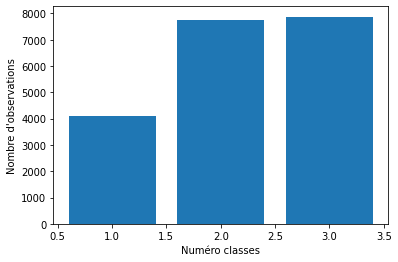

In [ ]:
# Distribution des classes
unique, counts = np.unique(gnd, return_counts=True)
plt.bar(unique, counts)
plt.xlabel("Numéro classes")
plt.ylabel("Nombre d'observations")

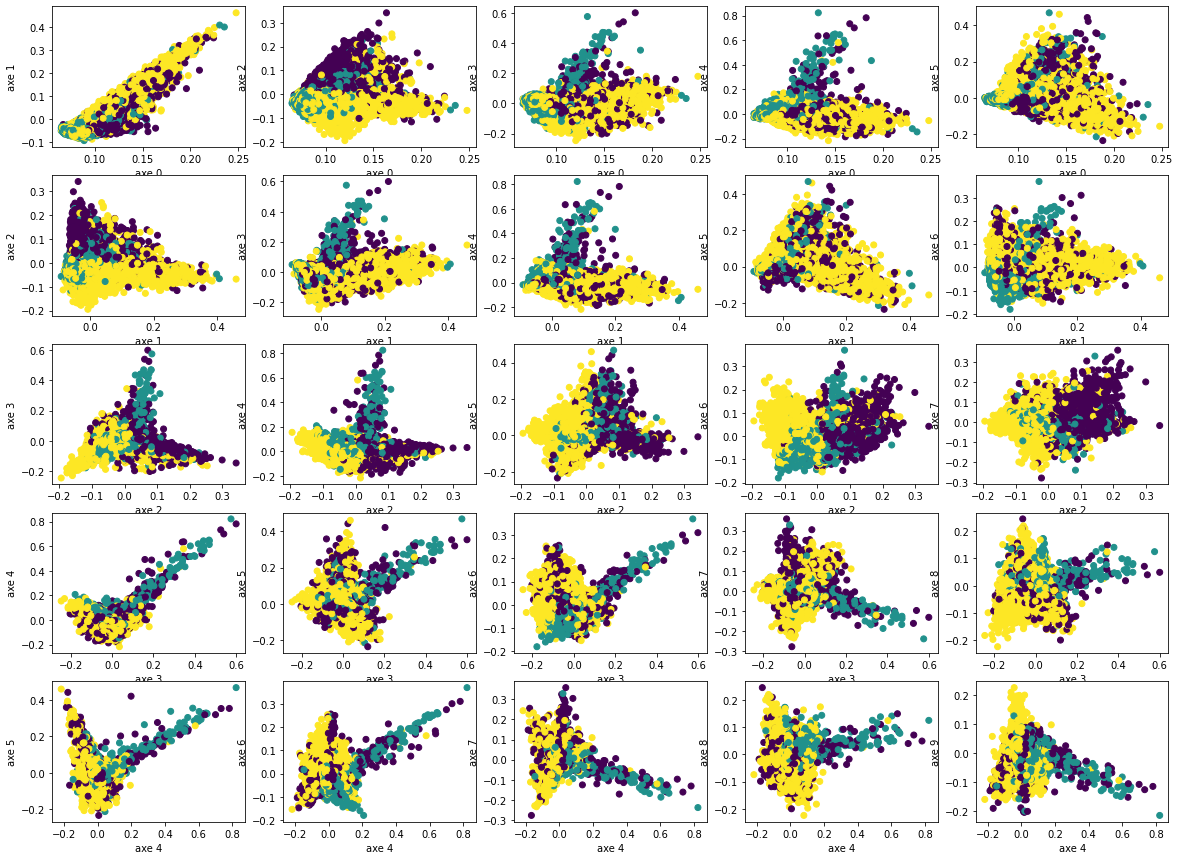

In [ ]:
# Projection sur l'espace des features
svd = TruncatedSVD(n_components=10).fit(fea)
X = svd.transform(fea)
pos = 1
plt.figure(figsize=(20,15))
for i in range(5):
  for j in range(i+1, i+5+1):
    plt.subplot(5,5,pos)
    plt.scatter(X[:,i], X[:,j], c=gnd.flatten())
    plt.xlabel(f"axe {i}")
    plt.ylabel(f"axe {j}")
    pos+=1

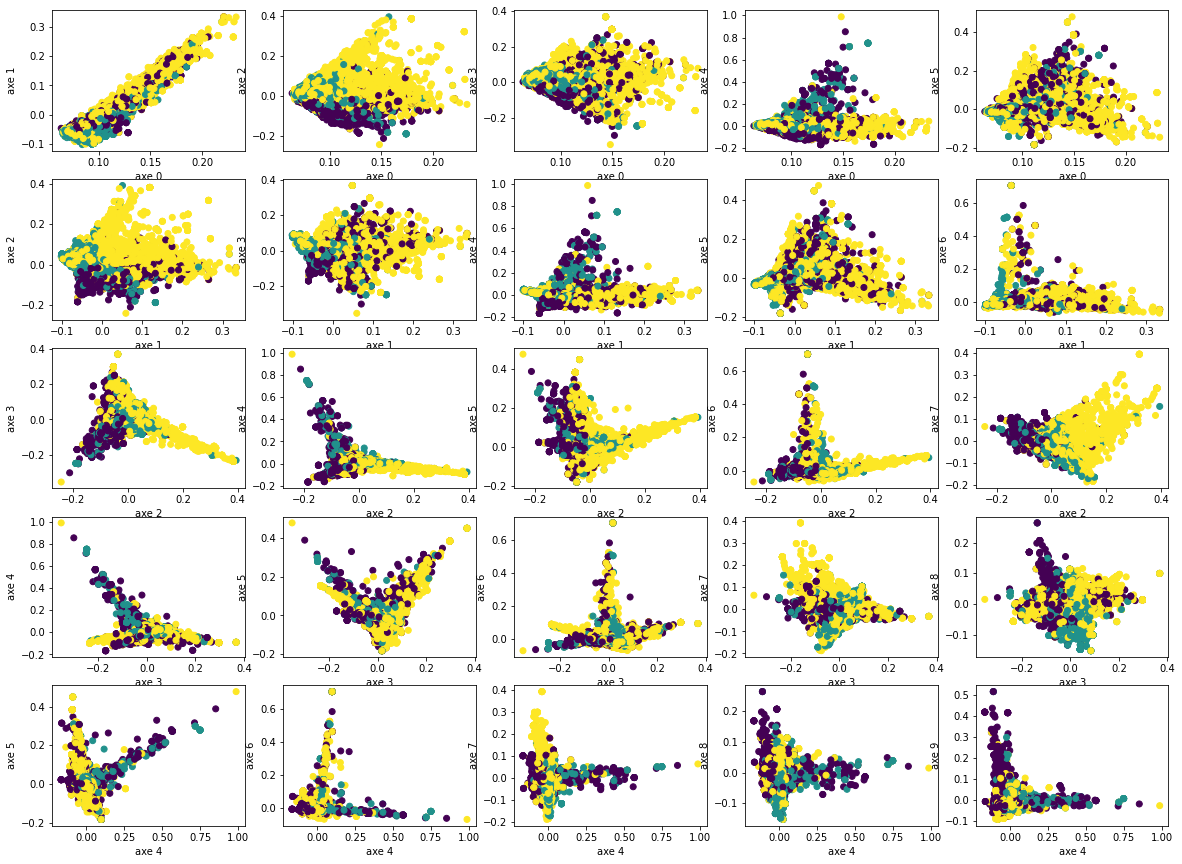

In [ ]:
# Projection sur la combinaison des matrices
svd = TruncatedSVD(n_components=10).fit(M)
X = svd.transform(M)
pos = 1
plt.figure(figsize=(20,15))
for i in range(5):
  for j in range(i+1, i+5+1):
    plt.subplot(5,5,pos)
    plt.scatter(X[:,i], X[:,j], c=gnd.flatten())
    plt.xlabel(f"axe {i}")
    plt.ylabel(f"axe {j}")
    pos+=1

## Baseline (classes déséquilibrées)

### Matrice fea

#### Application directe sans transformation

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(fea, gnd.flatten(),train_size=0.7)
models = [Bayesien, KNN, LDA, QDA, SVM_linear, SVM_rbf, RandomForest,Xgboost]
Names  = ["Bayesien", "KNN", "LDA", "QDA", "SVM_linear", "SVM_rbf", "RandomForest","Xgboost"]

In [ ]:
evaluation(models)

In [ ]:
scores(models)

Accuracy    Recall  Precision        F1       NMI       ARI
Bayesien      0.753381  0.753381   0.753381  0.753381  0.383209  0.395827
KNN           0.763016  0.763016   0.763016  0.763016  0.374657  0.397057
LDA           0.871197  0.871197   0.871197  0.871197  0.567986  0.641117
QDA           0.771805  0.771805   0.771805  0.771805  0.402588  0.429518
SVM_linear    0.865788  0.865788   0.865788  0.865788  0.560118  0.629674
SVM_rbf       0.882522  0.882522   0.882522  0.882522  0.596083  0.670292
RandomForest  0.886748  0.886748   0.886748  0.886748  0.609990  0.679551
Xgboost       0.893171  0.893171   0.893171  0.893171  0.620966  0.698555

#### Application avec transformation LSA

In [ ]:
svd = TruncatedSVD(100).fit(fea)
X = svd.transform(fea)
X_train, X_test, y_train, y_test = train_test_split(X, gnd.flatten(),train_size=0.7)

In [ ]:
evaluation(models)

In [ ]:
scores(models)

Accuracy    Recall  Precision        F1       NMI       ARI
Bayesien      0.632860  0.632860   0.632860  0.632860  0.195136  0.192826
KNN           0.799358  0.799358   0.799358  0.799358  0.424814  0.475322
LDA           0.832826  0.832826   0.832826  0.832826  0.488903  0.548262
QDA           0.758452  0.758452   0.758452  0.758452  0.384658  0.406042
SVM_linear    0.838235  0.838235   0.838235  0.838235  0.505128  0.562205
SVM_rbf       0.858181  0.858181   0.858181  0.858181  0.540184  0.608297
RandomForest  0.834348  0.834348   0.834348  0.834348  0.493736  0.552507
Xgboost       0.835193  0.835193   0.835193  0.835193  0.493090  0.554002

### Matrice combinée

#### Application directe sans transformation

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(M.toarray(), gnd.flatten(),train_size=0.7)

In [ ]:
evaluation(models)

In [ ]:
scores(models)

Accuracy    Recall  Precision        F1       NMI       ARI
Bayesien      0.726673  0.726673   0.726673  0.726673  0.329518  0.352651
KNN           0.811697  0.811697   0.811697  0.811697  0.433758  0.516032
LDA           0.818458  0.818458   0.818458  0.818458  0.447439  0.530018
QDA           0.787863  0.787863   0.787863  0.787863  0.407797  0.470687
SVM_linear    0.816937  0.816937   0.816937  0.816937  0.448392  0.528042
SVM_rbf       0.829277  0.829277   0.829277  0.829277  0.469515  0.556638
RandomForest  0.821839  0.821839   0.821839  0.821839  0.452208  0.540122
Xgboost       0.824206  0.824206   0.824206  0.824206  0.458839  0.543504

#### Application avec transformation LSA

In [ ]:
svd = TruncatedSVD(100).fit(M)
X = svd.transform(M)
X_train, X_test, y_train, y_test = train_test_split(X, gnd.flatten(),train_size=0.7)

In [ ]:
evaluation(models)

In [ ]:
scores(models)

Accuracy    Recall  Precision        F1       NMI       ARI
Bayesien      0.649256  0.649256   0.649256  0.649256  0.204016  0.218603
KNN           0.809669  0.809669   0.809669  0.809669  0.428093  0.510189
LDA           0.796653  0.796653   0.796653  0.796653  0.406564  0.481649
QDA           0.731406  0.731406   0.731406  0.731406  0.331303  0.359820
SVM_linear    0.794963  0.794963   0.794963  0.794963  0.409195  0.478238
SVM_rbf       0.824206  0.824206   0.824206  0.824206  0.457745  0.542379
RandomForest  0.817951  0.817951   0.817951  0.817951  0.444266  0.531159
Xgboost       0.810345  0.810345   0.810345  0.810345  0.433179  0.510966

## Imbalanced learn

### Matrice fea

In [ ]:
oversample = SMOTE()
X_oversample, y_oversample = oversample.fit_resample(fea, gnd.flatten())

#### Application directe sans transformation

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_oversample, y_oversample,train_size=0.7)
models = [Bayesien, KNN, LDA, QDA, SVM_linear, SVM_rbf, RandomForest,Xgboost]
Names  = ["Bayesien", "KNN", "LDA", "QDA", "SVM_linear", "SVM_rbf", "RandomForest","Xgboost"]

In [ ]:
evaluation(models)

In [ ]:
scores(models)

Accuracy    Recall  Precision        F1       NMI       ARI
Bayesien      0.782731  0.782731   0.782731  0.782731  0.426055  0.473880
KNN           0.785553  0.785553   0.785553  0.785553  0.449217  0.481313
LDA           0.877963  0.877963   0.877963  0.877963  0.596577  0.670970
QDA           0.809819  0.809819   0.809819  0.809819  0.467401  0.524732
SVM_linear    0.872743  0.872743   0.872743  0.872743  0.588988  0.659603
SVM_rbf       0.896445  0.896445   0.896445  0.896445  0.645635  0.717073
RandomForest  0.901383  0.901383   0.901383  0.901383  0.659768  0.729504
Xgboost       0.903922  0.903922   0.903922  0.903922  0.659007  0.734238

#### Application avec transformation LSA

In [ ]:
svd = TruncatedSVD(100).fit(X_oversample)
X = svd.transform(X_oversample)
X_train, X_test, y_train, y_test = train_test_split(X_oversample, y_oversample.flatten(),train_size=0.7)

In [ ]:
evaluation(models)

In [ ]:
scores(models)

Accuracy    Recall  Precision        F1       NMI       ARI
Bayesien      0.790209  0.790209   0.790209  0.790209  0.442540  0.488311
KNN           0.784424  0.784424   0.784424  0.784424  0.449396  0.478011
LDA           0.884594  0.884594   0.884594  0.884594  0.611124  0.686428
QDA           0.815604  0.815604   0.815604  0.815604  0.484924  0.538460
SVM_linear    0.884170  0.884170   0.884170  0.884170  0.616612  0.686418
SVM_rbf       0.906038  0.906038   0.906038  0.906038  0.670387  0.740867
RandomForest  0.906885  0.906885   0.906885  0.906885  0.674047  0.743166
Xgboost       0.904769  0.904769   0.904769  0.904769  0.662963  0.736720

### Matrice combinée

In [ ]:
oversample = SMOTE()
X_oversample, y_oversample = oversample.fit_resample(M, gnd.flatten())

#### Application directe sans transformation

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_oversample.toarray(), y_oversample.flatten(),train_size=0.7)

In [ ]:
evaluation(models)

In [ ]:
scores(models)

Accuracy    Recall  Precision        F1       NMI       ARI
Bayesien      0.750000  0.750000   0.750000  0.750000  0.362082  0.402888
KNN           0.830277  0.830277   0.830277  0.830277  0.491228  0.558898
LDA           0.820401  0.820401   0.820401  0.820401  0.464749  0.536732
QDA           0.813911  0.813911   0.813911  0.813911  0.459603  0.524910
SVM_linear    0.819836  0.819836   0.819836  0.819836  0.470252  0.537394
SVM_rbf       0.844667  0.844667   0.844667  0.844667  0.515290  0.590764
RandomForest  0.844667  0.844667   0.844667  0.844667  0.516697  0.591722
Xgboost       0.840011  0.840011   0.840011  0.840011  0.505547  0.580587

#### Application avec transformation LSA

In [ ]:
svd = TruncatedSVD(100).fit(X_oversample)
X = svd.transform(X_oversample)
X_train, X_test, y_train, y_test = train_test_split(X_oversample.toarray(), y_oversample.flatten(),train_size=0.7)

In [ ]:
evaluation(models)

In [ ]:
scores(models)

Accuracy    Recall  Precision        F1       NMI       ARI
Bayesien      0.753386  0.753386   0.753386  0.753386  0.362282  0.409284
KNN           0.832675  0.832675   0.832675  0.832675  0.493857  0.565018
LDA           0.820824  0.820824   0.820824  0.820824  0.464964  0.539028
QDA           0.822235  0.822235   0.822235  0.822235  0.475403  0.543524
SVM_linear    0.817861  0.817861   0.817861  0.817861  0.463611  0.533525
SVM_rbf       0.847630  0.847630   0.847630  0.847630  0.521462  0.598767
RandomForest  0.847065  0.847065   0.847065  0.847065  0.521114  0.598135
Xgboost       0.837613  0.837613   0.837613  0.837613  0.500585  0.576622